In [7]:
import os
import cv2

def preprocess_images_in_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(input_folder, filename)
            print(f"Processing: {image_path}")  

            image = cv2.imread(image_path)

            if image is None:
                print(f"Failed to load image: {image_path}")
                continue

            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Thresholding to find contours
            _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                # Find the largest contour
                largest_contour = max(contours, key=cv2.contourArea)

                # Get the bounding rectangle for the largest contour
                x, y, w, h = cv2.boundingRect(largest_contour)

                # Crop the image to the bounding rectangle
                cropped_image = image[y:y+h, x:x+w]

                # Define the output path
                output_path = os.path.join(output_folder, filename)

                # Save the cropped image with JPEG compression (85 quality)
                cv2.imwrite(output_path, cropped_image, [cv2.IMWRITE_JPEG_QUALITY, 85])

                # Check and display file sizes before and after cropping
                original_size = os.path.getsize(image_path)
                new_size = os.path.getsize(output_path)
                print(f"Saved cropped image to: {output_path}")
                print(f"Original size: {original_size / 1024:.2f} KB, New size: {new_size / 1024:.2f} KB")
            else:
                print(f"No contours found in image: {image_path}")  

def preprocess_all_categories(archive_folder):
    for dataset_type in ['train', 'test']:
        dataset_path = os.path.join(archive_folder, dataset_type)
        if os.path.isdir(dataset_path):
            for category_folder in os.listdir(dataset_path):
                category_path = os.path.join(dataset_path, category_folder)

                if os.path.isdir(category_path): 
                    # Output folder for cropped images
                    output_category_folder = os.path.join(dataset_path, f"cropped_{category_folder}")
                    preprocess_images_in_folder(category_path, output_category_folder)
                else:
                    print(f"Skipping non-directory item: {category_path}") 

# Path to the main folder containing datasets
archive_folder = 'archive'

# Run the preprocessing function
preprocess_all_categories(archive_folder)

Processing: archive/train/ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(20).jpg
Saved cropped image to: archive/train/cropped_ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(20).jpg
Original size: 304.73 KB, New size: 799.13 KB
Processing: archive/train/ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(214).jpg
Saved cropped image to: archive/train/cropped_ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(214).jpg
Original size: 686.90 KB, New size: 1131.62 KB
Processing: archive/train/ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(77).jpg
Saved cropped image to: archive/train/cropped_ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(77).jpg
Original size: 698.96 KB, New size: 1147.20 KB
Processing: archive/train/ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(185).jpg
Saved cropped image to: archive/train/cropped_ECG Images of Patient that have abnor

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

train_path = 'archive/train'
test_path = 'archive/test'
target_width = 960
target_height = 540

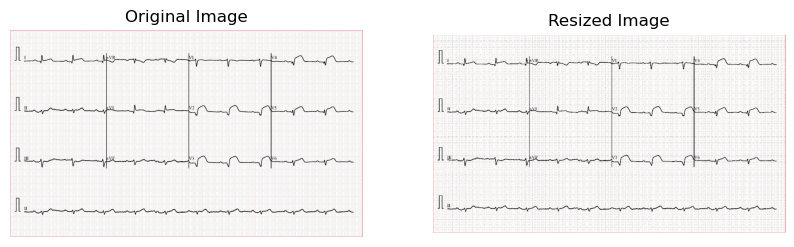

In [9]:
def preview_image(image_path, new_width, new_height):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return

    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Resized Image')
    plt.imshow(resized_image_rgb)
    plt.axis('off')

    plt.show()

image_path = 'archive/train/cropped_ECG Images of Myocardial Infarction Patients (240x12=2880)/MI(10).jpg'
preview_image(image_path, target_width, target_height)

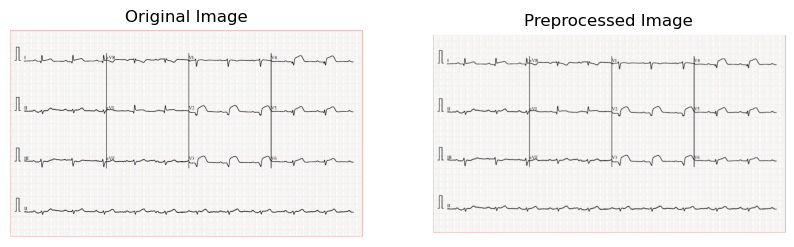

Found 745 images belonging to 4 classes.
Found 183 images belonging to 4 classes.
Found 448 images belonging to 4 classes.


In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

train_path = 'archive/train'
test_path = 'archive/test'
target_width = 960
target_height = 540

def preprocess_image(image_path, new_width, new_height):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    resized_image = cv2.resize(blurred_image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    return resized_image

def preview_image(image_path, new_width, new_height):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return

    resized_image = preprocess_image(image_path, new_width, new_height)

    if resized_image is None:
        return

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Preprocessed Image')
    plt.imshow(resized_image_rgb)
    plt.axis('off')
    plt.show()

image_path = 'archive/train/cropped_ECG Images of Myocardial Infarction Patients (240x12=2880)/MI(10).jpg'
preview_image(image_path, target_width, target_height)

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(target_height, target_width),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(target_height, target_width),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(target_height, target_width),
    batch_size=16,
    class_mode='categorical'
)


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_height, target_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)



In [11]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=8,
    callbacks=[early_stopping]
)

Epoch 1/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 279s 6s/step - accuracy: 0.2672 - loss: 53.2441 - val_accuracy: 0.4754 - val_loss: 1.3813
Epoch 2/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 292s 6s/step - accuracy: 0.3638 - loss: 1.7556 - val_accuracy: 0.3060 - val_loss: 6.6273
Epoch 3/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 270s 6s/step - accuracy: 0.3076 - loss: 2.5516 - val_accuracy: 0.3934 - val_loss: 1.1952
Epoch 4/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 263s 6s/step - accuracy: 0.6479 - loss: 0.9075 - val_accuracy: 0.7814 - val_loss: 0.5785
Epoch 5/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 268s 6s/step - accuracy: 0.9344 - loss: 0.1856 - val_accuracy: 0.9344 - val_loss: 0.1683
Epoch 6/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 266s 6s/step - accuracy: 0.9877 - loss: 0.0405 - val_accuracy: 0.9071 - val_loss: 0.3474
Epoch 7/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 265s 6s/step - accuracy: 0.9826 - loss: 0.0522 - val_accuracy: 0.9235 - val_loss: 0.2151
Epoch 8/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 264s 6s/step - accuracy: 0.9980 - loss: 0.0096 - val_accuracy: 0.9180 - val_loss

In [12]:
model.save('ecg_classification_model.h5')

print("Model saved as ecg_classification_model.h5")

Model saved as ecg_classification_model.h5


In [13]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

def load_and_evaluate_model(model_path, test_generator):
    # Load the saved model
    model = load_model(model_path)

    loss, accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")

    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    

    print('Classification Report:')
    print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

 
    print('Confusion Matrix:')
    print(confusion_matrix(test_generator.classes, y_pred))


model_path = 'ecg_classification_model.h5' 
load_and_evaluate_model(model_path, test_generator)

28/28 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9743 - loss: 0.0775
Test Loss: 0.06763984262943268
Test Accuracy: 0.9799107313156128
28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step
Classification Report:
                                                                          precision    recall  f1-score   support

      cropped_ECG Images of Myocardial Infarction Patients (240x12=2880)       0.21      0.21      0.21       112
     cropped_ECG Images of Patient that have History of MI (172x12=2064)       0.20      0.19      0.19       112
cropped_ECG Images of Patient that have abnormal heartbeat (233x12=2796)       0.23      0.23      0.23       112
                          cropped_Normal Person ECG Images (284x12=3408)       0.24      0.25      0.25       112

                                                                accuracy                           0.22       448
                                                               macro avg       0.22      0.22      0.22       448


In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 538, 958, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 269, 479, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 267, 477, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 133, 238, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 131, 236, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 65, 118, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 981760)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │   125,665,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,518,346 (959.47 MB)

 Trainable params: 125,759,172 (479.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 125,759,174 (479.73 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Predicted class: History of MI


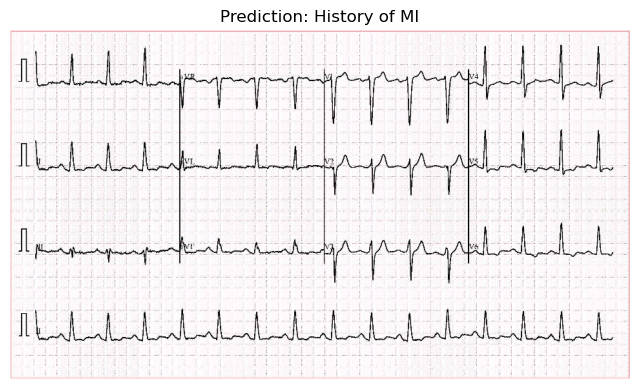

In [16]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

def preprocess_and_classify(image_path, model_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return

    # Preprocess the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped_image = image[y:y+h, x:x+w]
    else:
        print("No contours found in image.")
        return

    # Resize the image to match the model's input size
    target_width, target_height = 960, 540  # As per your model
    resized_image = cv2.resize(cropped_image, (target_width, target_height), interpolation=cv2.INTER_CUBIC)

    # Convert image to array and normalize
    image_array = img_to_array(resized_image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    # Load the trained model
    model = load_model(model_path)

    # Predict the class
    predictions = model.predict(image_array)
    class_index = np.argmax(predictions[0])
    
    # Define class labels
    class_labels = ['Myocardial', 'Abnormal heartbeat', 'History of MI', 'Normal Person']

    # Output the result
    predicted_class = class_labels[class_index]
    print(f"Predicted class: {predicted_class}")

    # Convert BGR image (from OpenCV) to RGB for Matplotlib
    resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Display the image with the prediction using Matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(resized_image_rgb)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage
image_path = 'org/test/ECG Images of Patient that have abnormal heartbeat (233x12=2796)/test (3).jpg'
model_path = 'ecg_classification_model.h5'
preprocess_and_classify(image_path, model_path)